In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import xarray as xr

# Customized Derivatives

## Extrapolation in volume

There may be some cases where a custom derivative needs to be written. Most likely, this will be when you can't write the necessary averages in terms of the observable and a specific Hamiltonian or thermodynamic conjugate variable. For instance, this might occur when extrapolating over volume in the NVT ensemble (see https://aip.scitation.org/doi/10.1063/5.0014282). In these cases, it is useful to know how to write custom derivative calculation functions and merge them back into the capabilities of the `thermoextrap` package.

This example will be based on the code found in xpan_vol.py, with sections of that file reproduced here for pedogogical purposes.

First, it is useful to know the structure of how extrapolation coefficients (derivatives) are calculated in `thermoextrap`. Handily, there is a class called `Coefs` that uses functions or arrays of functions to compute derivatives at specific orders. Typically, these functions are generated using sympy based on known relationships between the derivatives and moments of the observable and Hamiltonian. However, they can instead be specified manually.

In [2]:
from thermoextrap.xtrapy.core import Coefs

help(Coefs)    

Help on class Coefs in module thermoextrap.xtrapy.core:

class Coefs(builtins.object)
 |  Coefs(funcs, exprs=None)
 |  
 |  class to handle coefficients in taylor expansion
 |  
 |  Methods defined here:
 |  
 |  __init__(self, funcs, exprs=None)
 |      Parameters
 |      ----------
 |      funcs : array-like
 |          array of functions.
 |          funcs[n] is the nth derivative of function
 |      exprs : array-like, optional
 |          optional placeholder for sympy expressions corresponding to the
 |          lambdified functions in `funcs`
 |  
 |  coefs(self, *args, order, norm=True, minus_log=False)
 |  
 |  xcoefs(self, data, order=None, norm=True, minus_log=False, order_dim='order')
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  from_sympy(exprs, args) from builtins.type
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict

Our goal here will be to extrapolate in volume (or 1D length) for the 1D ideal gas test system.

To extrapolate in volume we need observable values at each snapshot along with values of the virial at each snapshot. For the ideal gas system, the virial is given by $W = -\sum_{i} \frac{\mathrm{d}U}{\mathrm{d}x_{i}} x_{i} = -\sum_{i} a x_{i}$, which for $a=1$ leads us to $W = -N \langle x \rangle$, where the average is over all particles of a given configuration. For the purposes of extrapolation, we need a dimensionless virial, so $W$ will be multiplied by $\beta$.

For any observable, there is a unique term that appears in the derivative with respect to system size or volume, specifically $\langle \sum_{i} \frac{\partial Y}{\partial x_i} x_{i}$ where $Y$ is the observable and $x_i$ is the $i^\mathrm{th}$ degree of freedom. In the ideal gas system at hand, $Y = \frac{1}{N} \sum_{i} x_{i}$ so that this correction term is equal to the observable itself, $Y = \langle x \rangle$, with again the average here only over all particles. It is interesting that the virial is then exactly $N$ times larger than this correction term. This is typical, as the virial will scale with the number of degrees of freedom in the system. As a result the correction term is 1000 times smaller than the other two terms appearing in the first derivative with respect to system size, $L$. However, the other two terms nearly cancel, resulting in a small difference the same order of magnitude as the correction term. For any system you work with, you should check the magnitude of the unique correction term, either visually or by deriving and computing it.

Getting back to the code, below is a custom derivative calculation function appearing in xpan_vol.py. This will actually work for any extrapolation in volume for the NVT ensemble, not just for the 1D ideal gas test system.

In [3]:
class VolumeDerivFuncs(object):
    """Calculates specific derivative values at refV with data x and W.
    Only go to first order for volume extrapolation.
    Here W represents the virial instead of the potential energy.
    """

    def __getitem__(self, order):
        # Check to make sure not going past first order
        if order > 1:
            raise ValueError(
                "Volume derivatives cannot go past 1st order"
                + " and received %i" % order
                + "\n(because would need derivatives of forces)"
            )
        else:
            return self.create_deriv_func(order)

    @staticmethod
    def create_deriv_func(order):

        def func(W, xW, dxdq, volume, ndim=1):
            """
            dxdq is <sum_{i=1}^N dy/dx_i x_i>

            for ideal gas
            """
            # NOTE: W here has beta in it:
            # that is W <- beta * virial

            # Zeroth order derivative
            if order == 0:
                deriv_val = xW[0]
            # First order derivative
            else:
                deriv_val = (-xW[0] * W[1] + xW[1] + dxdq) / (volume * ndim)
            return deriv_val

        return func


There are two key components in the above class: a `__getitem__` method and a `create_deriv_func` method. `__getitem__` is used to specify which order of derivative we want and return it - if this was an array of functions, we could just store the array and access them for the appropriate order. Here, this method just ensures that we don't try and go past 1st order in our derivatives (because that is not implemented) and returns the derivative function shown. The `create_deriv_func` returns the appropriate derivative at the specified order. The function it returns takes as inputs the virial moments (would be array of potential energy moments in other scenarios), array of moments of the product of $x$ and $W$, an explicit derivative term for of the observable with respect to the extrapolation variable, and the volume (or $L$ for the 1D ideal gas here). The last argument, `ndim`, is the dimensionality of the system, so just 1 for the 1D ideal gas, but would be 3 in more typical systems.

In [4]:
# Import idealgas module
from thermoextrap.xtrapy import idealgas

# Set temperature and volumes
beta = 1.0
volumes = np.arange(0.5, 10.0, 0.5)

# Define our reference size to extrapolated from
volume_ref = volumes[9]

npart = 1000 #Number of particles (in single configuration)
nconfig = 100_000 #Number of configurations

# And generate new data at this reference size, using a beta of 1.0 for simplicity
xdatavol, udatavol = idealgas.generate_data((nconfig, npart), beta=beta, vol=volume_ref)

# Wrap with xarray
xdatavol = xr.DataArray(xdatavol, dims=['rec'])
udatavol = xr.DataArray(udatavol, dims=['rec'])

#For the IG model, this is the same as the negative of the number of particles multiplied by the average position
#(for a=1)
#And we have to multiply by beta to make the virial dimensionless
wdatavol = -1.0 * npart * xdatavol

Next we create and train our volume extrapolation model and check its outputs. You can look at `factory_extrapmodel` in xpan_vol.py, but it's nearly identical to that in xpan_beta.py, but uses specialized data objects and Coefs models. We have already demonstrated above how to specify custom derivatives for the Coefs model.

To create a special data object, follow `DataValuesVolume` in xpan_vol.py, reproduced below, where a base data class is extended to also track the quantity `dxdqv`, or the specific derivative of the observable with respect to the extrapolation variable and is unique for every observable (see https://aip.scitation.org/doi/10.1063/5.0014282). Basically, extra data information can be passed in to the argument `meta` as a dictionary, which allows the base `DataValues` class to be extend with additional arguments. These arguments can be accessed and checked since they will be crucial information passed to the custom derivative calculation function. Note that there is a method `xcoefs_args` that is provided to the function to calculate coefficients, which should mirror the input structure in the above custom derivative function, as this describes what from the data gets passed to that function.

In [7]:
from thermoextrap.xtrapy.data import DataValues

class DataValuesVolume(DataValues):
    def __init__(
        self,
        uv,
        xv,
        order,
        meta,
        rec_dim="rec",
        umom_dim="umom",
        deriv_dim=None,
        skipna=False,
        chunk=None,
        compute=None,
        build_aves_kws=None,
    ):

        for k in ["volume", "dxdqv"]:
            assert k in meta

        if "ndim" not in meta:
            meta["ndim"] = 3

        super(DataValuesVolume, self).__init__(
            uv=uv,
            xv=xv,
            order=order,
            skipna=skipna,
            rec_dim=rec_dim,
            umom_dim=umom_dim,
            deriv_dim=deriv_dim,
            chunk=chunk,
            compute=compute,
            build_aves_kws=build_aves_kws,
            # meta data:
            meta=meta,
        )

    def dxdq(self):
        return self.meta["dxdqv"].mean(self.rec_dim, skipna=self.skipna)

    def resample_meta(self, indices):
        # resample "other" arrays
        out = self.meta.copy()
        out["dxdqv"] = out["dxdqv"][indices]
        return out
    
    @property
    def xcoefs_args(self):
        return (
            self.u_selector,
            self.xu_selector,
            self.dxdq,
            self.meta["volume"],
            self.meta["ndim"],
        )


In [8]:
import thermoextrap.xtrapy.xpan_vol as xpan_vol
import thermoextrap.xtrapy.xpan_vol_ig as xpan_vol_ig

In [9]:
xemv = xpan_vol.factory_extrapmodel(
    volume=volume_ref,
    # this is acually w
    uv=wdatavol,
    xv=xdatavol,
    # dxdqv = single observation of sum(dx/dq_i q_i) where q_i is the ith coordinate
    # for ideal gas, this is just xdata
    dxdqv=xdatavol,
    ndim=1
)

In [10]:
#Check the computation of derivatives
print("Model parameters (derivatives):")
print(xemv.xcoefs(norm=False).values)
print('\n')

#Finally, look at predictions
print("Model predictions:")
print(xemv.predict(volumes[:4]).values)
print('\n')

#And bootstrapped uncertainties
print("Bootstrapped uncertainties in predictions:")
print(xemv.resample(nrep=100).predict(volumes[:4]).std('rep').values)

Model parameters (derivatives):
[0.96591177 0.02706932]


Model predictions:
[0.84409984 0.8576345  0.87116916 0.88470382]


Bootstrapped uncertainties in predictions:
[0.00347274 0.00308669 0.00270069 0.00231479]


True extrapolation coefficients: [0.96608173 0.02736471]
	 With N_configs =     10: [0.97748851 0.02103266]
	 With N_configs =    100: [0.96609484 0.03666314]
	 With N_configs =   1000: [0.96442797 0.024789  ]
	 With N_configs =  10000: [0.96600138 0.02653583]
	 With N_configs = 100000: [0.96591177 0.02706932]


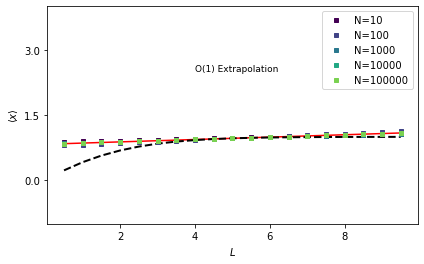

In [11]:
fig, ax = plt.subplots()

nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
ax.plot(volumes, idealgas.x_ave(beta, volumes), 'k--', linewidth=2.0)

#And the infinite sampling results for first order extrapolation
trueExtrap, trueDerivs = idealgas.x_vol_extrap(1, volume_ref, volumes, beta=beta)
ax.plot(volumes, trueExtrap, 'r-', zorder=0)
print('True extrapolation coefficients: {}'.format(trueDerivs))

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdatavol), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    xemv = xpan_vol.factory_extrapmodel(
        volume=volume_ref,
        # this is acually w
        uv=wdatavol[thisinds],
        xv=xdatavol[thisinds],
        dxdqv=xdatavol[thisinds],
        ndim=1
    )
    
    out = xemv.predict(volumes)
    print('\t With N_configs = %6i: %s'%(n, str(xemv.xcoefs(norm=False).values)))
    
    out.plot(marker='s', ms=4, color=nsampcolors[i], ls='None', label='N={}'.format(n), 
                              ax=ax)

ax.set_ylabel(r'$\langle x \rangle$')
ax.set_xlabel(r'$L$')

ax.annotate('O(1) Extrapolation', xy=(0.4, 0.7), xycoords='axes fraction', fontsize=9)

ax.set_ylim((-1.0, 4.0))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

ax.set_title(None)

plt.legend()
plt.show()